In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize

from sklearn.model_selection import train_test_split
import tensorflow as tf

from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means


random_seed = 54321
np.random.seed(random_seed)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

Using TensorFlow backend.


In [5]:
from collections import Generator
model_path = '..\\models\\'
print(model_path)

..\models\


In [6]:


tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')



In [8]:
data = pd.read_json("../data/train.json", orient='records')
data.head()
train_df = data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


In [9]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
#train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df['inc_angle_f'].replace(np.nan,0, inplace=True)
train_df.tail()

missing values in inc_angle:  133


,band_1,band_2,id,inc_angle,is_iceberg,inc_angle_f
1599,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",04e11240,na,0,0.0
1600,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",c7d6f6f8,na,0,0.0
1601,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",bba1a0f1,na,0,0.0
1602,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",7f66bb44,na,0,0.0
1603,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",9d8f326c,na,0,0.0


In [10]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

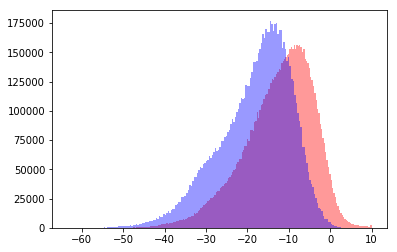

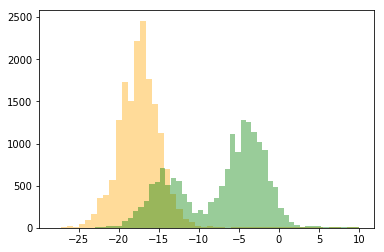

In [11]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

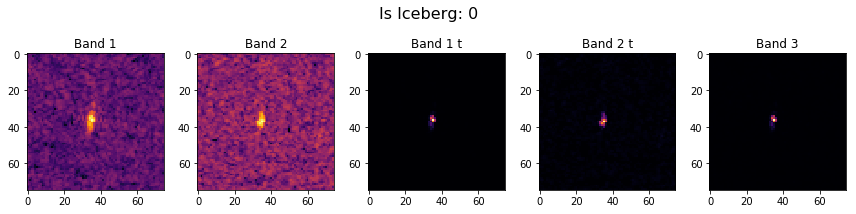

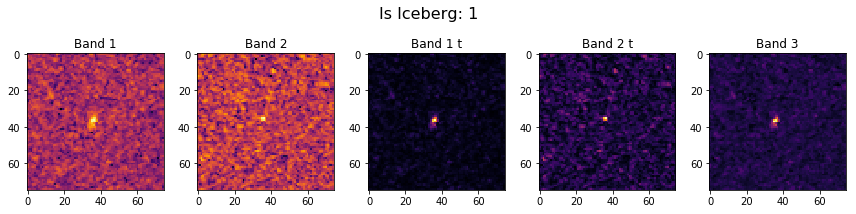

In [12]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")

In [13]:


y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle['index'] = y_angle.index


y_angle.head()




,is_iceberg,inc_angle_f,index
0,0,43.9239,0
1,0,38.1562,1
2,1,45.2859,2
3,0,43.8306,3
4,0,35.6256,4


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.3, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1122, 75, 75, 4)
(482, 75, 75, 4)


In [15]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)
        nn_denoised_temp = temp_data[0] #pass 4 bands for nn denoising input
        return [temp_stacked1, temp_stacked2, 
                nn_denoised_temp,
                temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

(1122, 75, 75, 4)


In [16]:
def denoising(img):
    img_list = []
    for i in range(4):
        image = normalize(img[:,:,i])
        img_list.append(ndimage.median_filter(image, 3))
    return np.stack(img_list,axis=2)

In [17]:


def apply_over_axis(func, data, mask=None, axis=0, *args, **kwargs):
    f_list = []
    for i in range(data.shape[axis]):
        if mask is None:
            f_list.append(func(data[i], *args, **kwargs))
        else:
            f_list.append(func(data[i], mask=mask[i], *args, **kwargs))
    return np.stack(f_list,axis=0)



In [18]:


#custom generator for denoising
from collections import Generator
class Datagen_denoising(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3]),axis=3)
        return temp_stacked, temp_stacked
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
        
datagen_denoising = Datagen_denoising(imagegen=datagen)
datagen_denoising_val = Datagen_denoising(imagegen=datagen_val)



In [19]:


m_input = Input(shape=(75,75,4), name='m_input')

#conv layers for main_input
x1 = BatchNormalization()(m_input)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
m_output = Conv2D(4, (3,3), activation='linear', name='m_output')(x1)
model_denoise = Model(inputs=[m_input,], outputs=[m_output], name='Model_nn_denoising')

model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='mean_squared_error',
metrics=['mae'])



In [20]:
#model training
start_time = time.monotonic()

H = model_denoise.fit_generator(datagen_denoising.flow(X, y_angle, batch_size=8),
                    steps_per_epoch=len(X)/8,
                    validation_data=datagen_denoising_val.flow(X, y_angle, batch_size=8, shuffle=False), 
                    validation_steps=len(X)/8,
                    #validation_data=[X_val,y_val],
                    epochs=10)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Epoch 1/10
201/200 [==============================] - 40s 201ms/step - loss: 18.5685 - mean_absolute_error: 2.4129 - val_loss: 11.9815 - val_mean_absolute_error: 1.8933
Epoch 2/10
201/200 [==============================] - 39s 196ms/step - loss: 12.2612 - mean_absolute_error: 1.9531 - val_loss: 17.9345 - val_mean_absolute_error: 2.3938
Epoch 3/10
201/200 [==============================] - 39s 195ms/step - loss: 12.7549 - mean_absolute_error: 1.9610 - val_loss: 9.8380 - val_mean_absolute_error: 1.9290
Epoch 4/10
201/200 [==============================] - 40s 199ms/step - loss: 12.2315 - mean_absolute_error: 1.9615 - val_loss: 5.9050 - val_mean_absolute_error: 1.6018
Epoch 5/10
201/200 [==============================] - 40s 200ms/step - loss: 9.5024 - mean_absolute_error: 1.7561 - val_loss: 5.1494 - val_mean_absolute_error: 1.3987
Epoch 6/10
201/200 [==============================] - 40s 197ms/step - loss: 9.1717 - mean_absolute_error: 1.7077 - val_loss: 5.1276 - val_mean_absolute_error:

In [21]:


X_nn_denoised = model_denoise.predict(X, verbose=1)



1604/1604 [==============================] - 11s 7ms/step


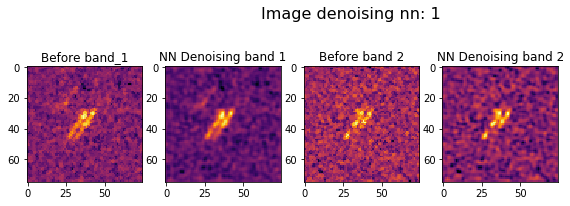

In [22]:
index=8
original_index = y_train_sample.iloc[index].name
cmap="inferno"
fig = plt.figure(figsize=(12,6))
fig.suptitle("Image denoising nn: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before band_1")
ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("NN Denoising band 1")
ax2.imshow(X_nn_denoised[original_index][:,:,0], cmap=cmap)
ax3 = fig.add_subplot(253)
ax3.set_title("Before band 2")
ax3.imshow(X_train_sample[index][:,:,1], cmap=cmap)
ax4 = fig.add_subplot(254)
ax4.set_title("NN Denoising band 2")
ax4.imshow(X_nn_denoised[original_index][:,:,1], cmap=cmap)
plt.show()

In [23]:
model_code="CNN_2017_12_21_v21"
model_comment="2 CNN inputs 3,3 conv filters - 3rd input nn denoising, na=0"

In [24]:
%%writefile current_model.py

def InputBlock(x, dropout=0.2, prefix=''):
    #conv layers for input
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    return(x)

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')
aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn')

x1 = InputBlock(main_input, prefix='m_input')
x2 = InputBlock(aux_input, prefix='a_input')
x3 = model_denoise(aux_input_nn)
x3 = InputBlock(x3,dropout=0.2, prefix='a_input_nn')

x = Concatenate(axis=3)([x1,x2,x3])
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#conv-block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#conv-block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
#flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
#x1 = BatchNormalization()(angle_input)
merged = Concatenate()([x, angle_input])

#dense-block
x = Dense(513, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input, 
                        aux_input_nn, 
                        angle_input], 
                        outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])

Writing current_model.py


In [25]:
%run -i current_model.py

In [31]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.66
    patience = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

def step_decay2(epoch):
    initial_lrate = 0.000001
    drop = 0.66
    patience = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001):
        self.initial_lrate=initial_lrate

    def step_decay(epoch,logs):
        initial_lrate = self.initial_lrate
        drop = 0.66
        patience = 15.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

def get_callbacks(filepath, patience=10, step_decay=step_decay):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    lrScheduler = LearningRateScheduler(step_decay)
    return [msave, lrScheduler]

In [32]:
model_f.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
aux_input_nn (InputLayer)       (None, 75, 75, 4)    0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
Model_nn_denoising (Model)      (None, 75, 75, 4)    1252        aux_input_nn[0][0]               
__________________________________________________________________________________________________
batch_norm

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
SVG(model_to_dot(model_f).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [34]:


#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay)



In [36]:
#model training
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=24),
                    steps_per_epoch=len(X_train_sample)/24,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=24, shuffle=False), 
                    validation_steps=len(X_val)/12,
                    #validation_data=[X_val,y_val],
                    epochs=15, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  0.001
Epoch 1/15
47/46 [==============================] - 413s 9s/step - loss: 0.3217 - acc: 0.8617 - val_loss: 0.2879 - val_acc: 0.8565
Epoch 2/15
47/46 [==============================] - 404s 9s/step - loss: 0.3202 - acc: 0.8611 - val_loss: 0.2627 - val_acc: 0.8798
Epoch 3/15
47/46 [==============================] - 401s 9s/step - loss: 0.3174 - acc: 0.8546 - val_loss: 0.2898 - val_acc: 0.8947
Epoch 4/15
47/46 [==============================] - 403s 9s/step - loss: 0.3215 - acc: 0.8703 - val_loss: 0.2289 - val_acc: 0.8968
Epoch 5/15
47/46 [==============================] - 395s 8s/step - loss: 0.2819 - acc: 0.8907 - val_loss: 0.2153 - val_acc: 0.9032
Epoch 6/15
47/46 [==============================] - 308s 7s/step - loss: 0.2863 - acc: 0.8836 - val_loss: 0.2247 - val_acc: 0.9085
Epoch 7/15
47/46 [==============================] - 210s 4s/step - loss: 0.2806 - acc: 0.8809 - val_loss: 0.2678 - val_acc: 0.8628
Setting learning rate:  0.00066
Epoch 8/15
47/46 [===

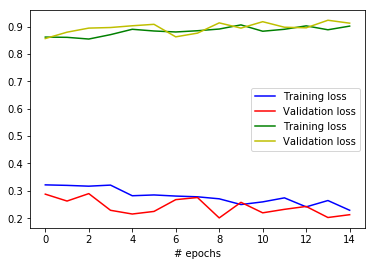

In [37]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.plot(H.history['acc'], color="g", label='Training loss')
plt.plot(H.history['val_acc'], color="y", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [38]:
#addtional training epochs
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay2)
start_time = time.monotonic()

H2 = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=24),
                    steps_per_epoch=len(X_train_sample)/24,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=32, shuffle=False), 
                    validation_steps=len(X_val)/12,
                    #validation_data=[X_val,y_val],
                    epochs=14, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  1e-06
Epoch 1/14
47/46 [==============================] - 217s 5s/step - loss: 0.2104 - acc: 0.9051 - val_loss: 0.2098 - val_acc: 0.9145
Epoch 2/14
47/46 [==============================] - 222s 5s/step - loss: 0.2108 - acc: 0.9125 - val_loss: 0.2011 - val_acc: 0.9201
Epoch 3/14
47/46 [==============================] - 222s 5s/step - loss: 0.2135 - acc: 0.9152 - val_loss: 0.2026 - val_acc: 0.9169
Epoch 4/14
47/46 [==============================] - 223s 5s/step - loss: 0.2050 - acc: 0.9116 - val_loss: 0.2072 - val_acc: 0.9133
Epoch 5/14
47/46 [==============================] - 217s 5s/step - loss: 0.2096 - acc: 0.9096 - val_loss: 0.2052 - val_acc: 0.9116
Setting learning rate:  6.6e-07
Epoch 6/14
47/46 [==============================] - 218s 5s/step - loss: 0.2177 - acc: 0.9164 - val_loss: 0.2024 - val_acc: 0.9100
Epoch 7/14
47/46 [==============================] - 222s 5s/step - loss: 0.2132 - acc: 0.9140 - val_loss: 0.1979 - val_acc: 0.9105
Epoch 8/14
47/46 [===

In [39]:
for key in H.history:
    H.history[key].extend(H2.history[key])

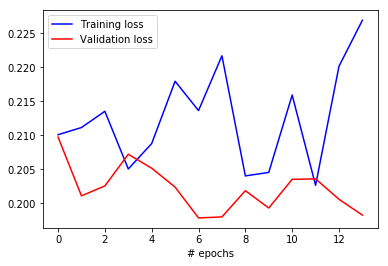

In [40]:
plt.plot(H2.history['loss'], color="b", label='Training loss')
plt.plot(H2.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

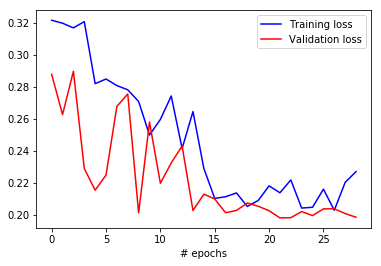

In [41]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [49]:
model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
model_f.save(model_object_path)
model_f = load_model(model_object_path)

In [50]:
argmin = np.array(H.history["val_loss"]).argmin()
argmax_acc = np.array(H.history["val_acc"]).argmax()
with open('current_model.py','r') as model_python_code_file:
    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
                                    "val_loss [min]":[H.history['val_loss'][argmin]],
                                    "epoch [val_loss [min]]":argmin,
                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
                                    
                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
                                    "epoch [val_acc [max]]":argmax_acc,
                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
                                    
                                    "model_path":[model_object_path],
                                    "model_weights_path":[model_best_weights_path],
                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
                                    "model_comment":[model_comment]
                                })
                               
models_history = models_history[["timestamp", 
                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
                                 "model_path","model_weights_path","model_python_code","model_comment"]]
models_history.head()

,timestamp,epoch [val_loss [min]],val_loss [min],training_loss [val_loss [min]],val_acc [val_loss [min]],training_acc [val_loss [min]],epoch [val_acc [max]],val_acc [max],training_loss [val_acc [max]],val_loss [val_acc [max]],training_acc [val_acc [max]],model_path,model_weights_path,model_python_code,model_comment
0,2017_12_29_01_37_29,21,0.197883,0.213648,0.910543,0.913547,13,0.923404,0.264547,0.202499,0.888592,..\models\model.CNN_2017_12_21_v21_2017_12_29_...,..\models\weights.CNN_2017_12_21_v21_2017_12_2...,"\ndef InputBlock(x, dropout=0.2, prefix=''):\n...","2 CNN inputs 3,3 conv filters - 3rd input nn d..."


In [51]:
print("Min validation loss epoch:")
print("epoch: %d" %(argmin),
      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
     )
print("Max validation accuracy epoch:")
print("epoch: %d" %(argmax_acc),
      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
     )
print("model comment:", model_comment)

Min validation loss epoch:
epoch: 21 ; val loss [min] 0.1979:  ; training loss: 0.2136 ; val acc: 0.9105 ; training acc: 0.9135 
Max validation accuracy epoch:
epoch: 13 ; val loss 0.2025:  ; training loss: 0.2645 ; val acc [max]: 0.9234 ; training acc: 0.8886 
model comment: 2 CNN inputs 3,3 conv filters - 3rd input nn denoising, na=0


In [52]:
with open('models_history.csv', 'a') as f:
    models_history.to_csv(f, header=False,index=False)
    models_history.to_csv(f, index=False)

In [53]:


df = pd.read_csv('models_history.csv')
df.tail()



,2017_12_29_01_37_29,21,0.1978825735398375,0.21364773562885223,0.9105431309904153,0.913547234101729,13,0.9234042548118754,0.2645469595563603,0.20249918604150732,0.8885918033314261,..\models\model.CNN_2017_12_21_v21_2017_12_29_01_37_29.hdf5,..\models\weights.CNN_2017_12_21_v21_2017_12_29_01_37_29.hdf5,"def InputBlock(x, dropout=0.2, prefix=''): #conv layers for input x = BatchNormalization()(x) x = Conv2D(64, (3,3), activation='relu')(x) x = MaxPooling2D((2, 2), strides=(2, 2))(x) x = BatchNormalization()(x) x = Dropout(dropout)(x) return(x) main_input = Input(shape=(75,75,2), name='main_input') aux_input = Input(shape=(75,75,3), name='aux_input') aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn') x1 = InputBlock(main_input, prefix='m_input') x2 = InputBlock(aux_input, prefix='a_input') x3 = model_denoise(aux_input_nn) x3 = InputBlock(x3,dropout=0.2, prefix='a_input_nn') x = Concatenate(axis=3)([x1,x2,x3]) #x = BatchNormalization()(x) #x = Dropout(0.2)(x) #conv-block x = Conv2D(128, (3, 3), activation='relu')(x) x = MaxPooling2D((2, 2), strides=(2, 2))(x) x = BatchNormalization()(x) x = Dropout(0.2)(x) #conv-block x = Conv2D(256, (3, 3), activation='relu')(x) x = MaxPooling2D((2, 2), strides=(2, 2))(x) x = BatchNormalization()(x) x = Dropout(0.2)(x) #flatten x = Flatten()(x) angle_input = Input(shape=[1], name='angle_input') #x1 = BatchNormalization()(angle_input) merged = Concatenate()([x, angle_input]) #dense-block x = Dense(513, activation='relu')(merged) x = BatchNormalization()(x) x = Dropout(0.2)(x) #dense-block x = Dense(256, activation='relu')(x) x = BatchNormalization()(x) x = Dropout(0.2)(x) main_output = Dense(1, activation='sigmoid', name='main_output')(x) model_f = Model(inputs=[main_input,aux_input, aux_input_nn, angle_input], outputs=[main_output]) model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0), loss='binary_crossentropy', metrics=['accuracy'])","2 CNN inputs 3,3 conv filters - 3rd input nn denoising, na=0"
0,timestamp,epoch [val_loss [min]],val_loss [min],training_loss [val_loss [min]],val_acc [val_loss [min]],training_acc [val_loss [min]],epoch [val_acc [max]],val_acc [max],training_loss [val_acc [max]],val_loss [val_acc [max]],training_acc [val_acc [max]],model_path,model_weights_path,model_python_code,model_comment
1,2017_12_29_01_37_29,21,0.1978825735398375,0.21364773562885223,0.9105431309904153,0.913547234101729,13,0.9234042548118754,0.2645469595563603,0.20249918604150732,0.8885918033314261,..\models\model.CNN_2017_12_21_v21_2017_12_29_...,..\models\weights.CNN_2017_12_21_v21_2017_12_2...,"\r\ndef InputBlock(x, dropout=0.2, prefix=''):...","2 CNN inputs 3,3 conv filters - 3rd input nn d..."
2,2017_12_29_01_37_29,21,0.1978825735398375,0.21364773562885223,0.9105431309904153,0.913547234101729,13,0.9234042548118754,0.2645469595563603,0.20249918604150732,0.8885918033314261,..\models\model.CNN_2017_12_21_v21_2017_12_29_...,..\models\weights.CNN_2017_12_21_v21_2017_12_2...,"\r\ndef InputBlock(x, dropout=0.2, prefix=''):...","2 CNN inputs 3,3 conv filters - 3rd input nn d..."
3,timestamp,epoch [val_loss [min]],val_loss [min],training_loss [val_loss [min]],val_acc [val_loss [min]],training_acc [val_loss [min]],epoch [val_acc [max]],val_acc [max],training_loss [val_acc [max]],val_loss [val_acc [max]],training_acc [val_acc [max]],model_path,model_weights_path,model_python_code,model_comment
4,2017_12_29_01_37_29,21,0.1978825735398375,0.21364773562885223,0.9105431309904153,0.913547234101729,13,0.9234042548118754,0.2645469595563603,0.20249918604150732,0.8885918033314261,..\models\model.CNN_2017_12_21_v21_2017_12_29_...,..\models\weights.CNN_2017_12_21_v21_2017_12_2...,"\r\ndef InputBlock(x, dropout=0.2, prefix=''):...","2 CNN inputs 3,3 conv filters - 3rd input nn d..."


In [54]:
model_f.load_weights(model_best_weights_path)

In [55]:
model_f.evaluate(X_val,y_val, verbose=1, batch_size=64)

ValueError: The model expects 4 input arrays, but only received one array. Found: array with shape (482, 75, 75, 4)

In [56]:


test_df = pd.read_json("../data/test.json")



In [57]:
test_df.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [60]:
test_df['inc_angle_f'] = pd.to_numeric(test_df['inc_angle'], errors='coerce')

print("missing values in inc_angle: ", test_df['inc_angle_f'].isnull().sum())

test_df['inc_angle_f'].replace(np.nan,0, inplace=True)

missing values in inc_angle:  0


In [61]:
t_band_1, t_band_2, t_band_1_t, t_band_2_t, t_band_3, X_test = get_bands(test_df)

y_angle_test = test_df.loc[:,['is_iceberg','inc_angle_f']]

y_angle_test['index'] = y_angle_test.index

current_model.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  #conv layers for input
E:\InstalledSoftware\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [62]:
predictions = model_f.predict_generator(datagen_angle_val.flow(X_test, y_angle_test, batch_size=32, shuffle=False),steps = len(X_test)/31, verbose=1)

272/271 [==============================] - 553s 2s/step


In [63]:
submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions[:8424].reshape(-1)})
submission.head()

,id,is_iceberg
0,5941774d,0.009238
1,4023181e,0.741514
2,b20200e4,0.001286
3,e7f018bb,0.997163
4,4371c8c3,0.015011


In [64]:
submission.to_csv("../submission/submission102.csv", index=False)